In [1]:
import sklearn.datasets as datasets
import numpy as np
import re
import pandas as pd
import seaborn as sns
import os
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image
import cv2

## Getting our dataset

In [2]:
# Path where our data is located
base_path = "./asl_dataset/asl_dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df.head()

,filename,category
0,0/hand1_0_dif_seg_4_cropped.jpeg,0
1,z/hand5_z_bot_seg_4_cropped.jpeg,35
2,z/hand1_z_left_seg_1_cropped.jpeg,35
3,2/hand3_2_dif_seg_1_cropped.jpeg,2
4,h/hand4_h_bot_seg_1_cropped.jpeg,17


In [4]:
# Load the images and convert them to numpy arrays
pixel_arrays = []
for i,img in enumerate(df["filename"]):
    img = Image.open(base_path+img)  
    numpydata = asarray(img)
    pixel_arrays.append(numpydata)
df["pixel_data"] = pixel_arrays

In [5]:
df.head()

,filename,category,pixel_data
0,0/hand1_0_dif_seg_4_cropped.jpeg,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,z/hand5_z_bot_seg_4_cropped.jpeg,35,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,z/hand1_z_left_seg_1_cropped.jpeg,35,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,2/hand3_2_dif_seg_1_cropped.jpeg,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,h/hand4_h_bot_seg_1_cropped.jpeg,17,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [6]:
# Convert the pixel data to grayscale
gray_scale = []
for data in df["pixel_data"]:
    gray_data = data.mean(axis=2)
    gray_scale.append(gray_data.astype(np.uint8))

df["pixel_data"] = gray_scale


In [7]:
df.head()

,filename,category,pixel_data
0,0/hand1_0_dif_seg_4_cropped.jpeg,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,z/hand5_z_bot_seg_4_cropped.jpeg,35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,z/hand1_z_left_seg_1_cropped.jpeg,35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2/hand3_2_dif_seg_1_cropped.jpeg,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,h/hand4_h_bot_seg_1_cropped.jpeg,17,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


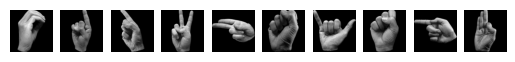

In [8]:
# Visualizar imágenes procesadas
for i in range(10):  # Mostrar las primeras 5 imágenes
    plt.subplot(1, 10, i+1)
    plt.imshow(df["pixel_data"].iloc[i], cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
def get_mask (gray_image):
    threshold = int(gray_image.max()//2)
    mask = cv2.inRange(gray_image,threshold,255)
    return mask

In [10]:
freq = {}
for cat in df["category"].unique():
    for val in df["category"]:
        if val == cat:
            if cat not in freq:
                freq[cat] = 1
            else:
                freq[cat] += 1
freq.keys()
freq.values()

dict_values([70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70])

In [11]:
df["pixel_data"][0].shape

(400, 400)

## Extracting the keypoints

In [12]:

# Function to generate a dense grid of keypoints
def generate_dense_keypoints(image, step_size=8):
    """
    Generate dense keypoints on a regular grid for a given image.
    
    Args:
    - image: Input image (grayscale).
    - step_size: Distance between keypoints in the grid.

    Returns:
    - dense_keypoints: List of dense keypoints.
    """
    h, w = image.shape
    dense_keypoints = [
        cv2.KeyPoint(x, y, step_size) 
        for y in range(0, h, step_size) 
        for x in range(0, w, step_size)
    ]
    return dense_keypoints

In [13]:
sift = cv2.SIFT_create()

keypoints = []
descriptors = []

In [14]:
for img in df["pixel_data"]:
    # Generate mask and dense keypoints
    mask = get_mask(img)
    dense_kp = generate_dense_keypoints(img)
    
    # Compute descriptors at dense keypoints
    _, des = sift.compute(img, dense_kp, mask)
    
    keypoints.append(dense_kp)
    descriptors.append(des)


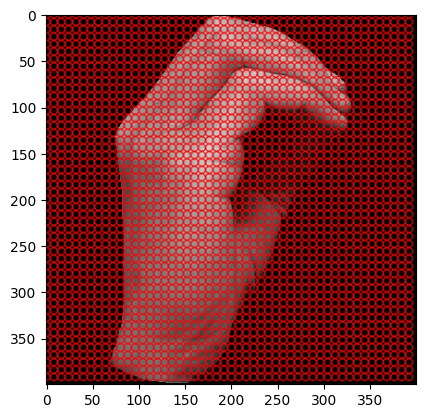

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


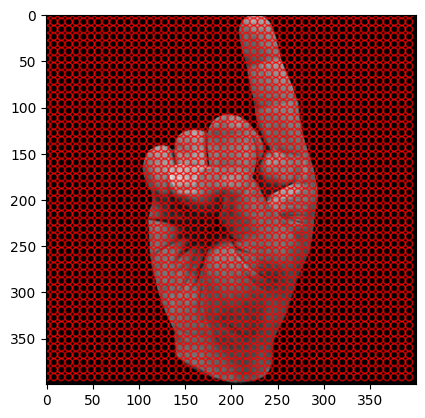

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


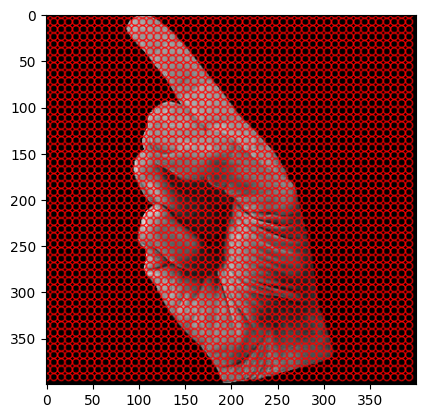

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


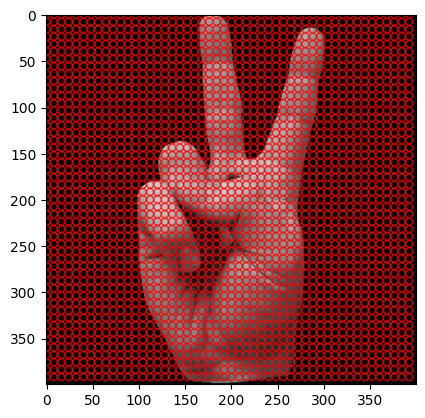

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


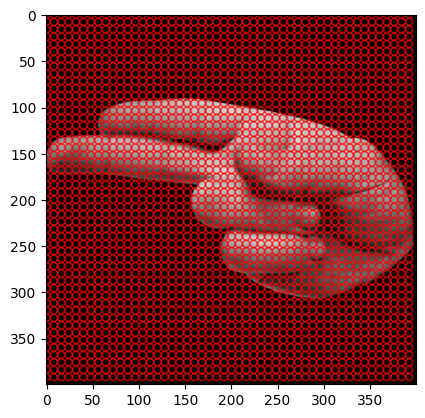

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


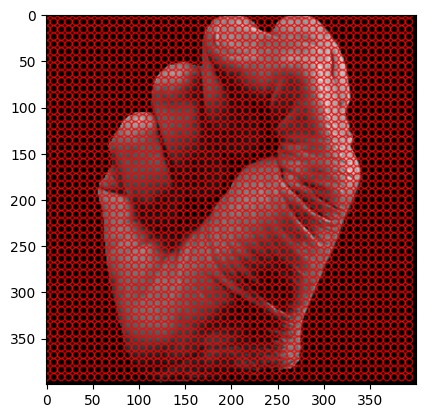

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


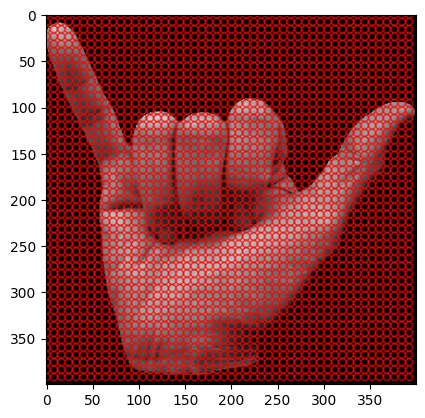

[[  0.   0.   0. ... 170. 167.  23.]
 [  0.   0.   0. ... 162.  37.   0.]
 [  0.   0.   0. ... 159.   2.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


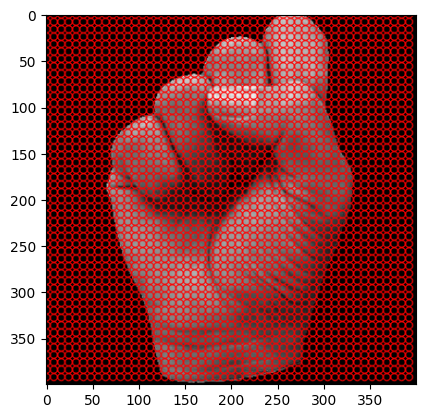

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


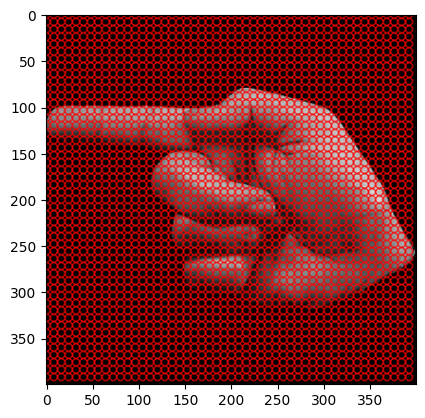

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


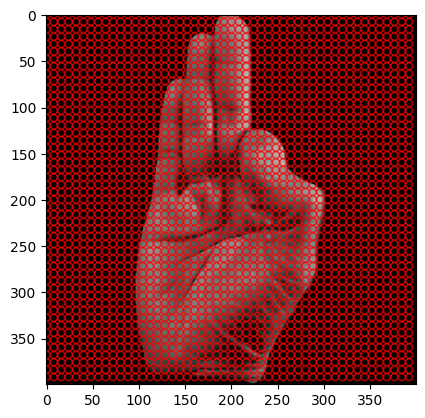

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
output_image = []
for x in range(10):
    output_image.append(cv2.drawKeypoints(df["pixel_data"][x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()
    print(descriptors[x])

## The Codebook

In [16]:

# Concatenate all descriptors
all_descriptors = []
for img_descriptors in descriptors:
    if img_descriptors is not None:  # Handle potential None values
        all_descriptors.extend(img_descriptors)

# Convert to a numpy array
all_descriptors = np.stack(all_descriptors)

In [17]:
np.random.seed(0)

sample_idx = np.random.randint(0, len(df)+1, 1000).tolist()

descriptors_sample = []

for n in sample_idx: # We get the descriptors of 1000 random shapes to establish the codebook
    descriptors_sample.append(np.array(descriptors[n]))

In [18]:
all_descriptors = []

for img_descriptors in descriptors_sample:
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)

# We join all the descriptors 
all_descriptors = np.stack(all_descriptors)

In [19]:
all_descriptors.shape

(2500000, 128)

## Kmeans

In [20]:
from sklearn.cluster import KMeans

k = 200  # Número de clusters
iters = 1  # Número de inicializaciones independientes

kmeans = KMeans(n_clusters=k, n_init=iters, max_iter=300, random_state=0)
kmeans.fit(all_descriptors)
codebook = kmeans.cluster_centers_
variance = kmeans.inertia_

## SVM

In [21]:
im_features = np.zeros((len(df["pixel_data"]), k), dtype=np.float32)
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is not None:
        for feature in img_descriptors:
            feature = feature.reshape(1, -1)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

In [22]:
df["category"]

0        0
1       35
2       35
3        2
4       17
        ..
2510    12
2511    17
2512    25
2513    19
2514     6
Name: category, Length: 2515, dtype: int64

In [23]:
#import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


#Normalizo los datos. TODO: Revisar si es necesario
scaler = StandardScaler().fit(im_features)
im_features = scaler.transform(im_features)


x_train, x_test, y_train, y_test = train_test_split(im_features, df["category"],train_size=0.6,shuffle=True,random_state=25)

svm = SVC(kernel='linear', C=1.0, gamma='scale')
svm.fit(x_train, y_train)


SVC(kernel='linear')

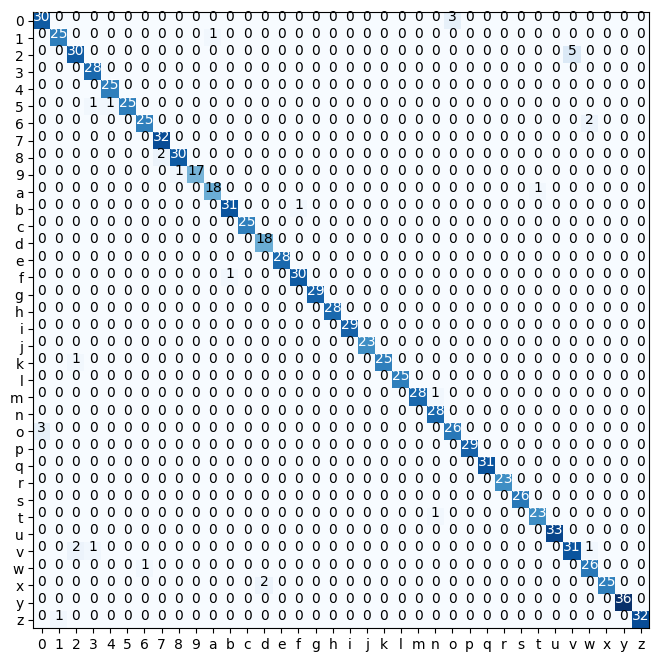

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = svm.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.xticks(np.array([i for i in range(cm.shape[0])]),categories.values())
plt.yticks(np.array([i for i in range(cm.shape[0])]),categories.values())

plt.show()


In [25]:
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.96      0.96      0.96        26
           2       0.91      0.86      0.88        35
           3       0.93      1.00      0.97        28
           4       0.96      1.00      0.98        25
           5       1.00      0.93      0.96        27
           6       0.96      0.93      0.94        27
           7       0.94      1.00      0.97        32
           8       0.97      0.94      0.95        32
           9       1.00      0.94      0.97        18
          10       0.95      0.95      0.95        19
          11       0.97      0.97      0.97        32
          12       1.00      1.00      1.00        25
          13       0.90      1.00      0.95        18
          14       1.00      1.00      1.00        28
          15       0.97      0.97      0.97        31
          16       1.00      1.00      1.00        29
 

In [26]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.967


In [27]:
# Aplicamos grid search para ver si mejoran los resultados
from sklearn.model_selection import GridSearchCV
svm = SVC()


param_grid = {
    'C': [0.1, 1, 10, 100],              # parámetro de regularización
    'gamma': ['scale', 'auto', 0.1, 1],  # gamma
    'kernel': ['linear', 'rbf', 'poly']  # kernel
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [28]:

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.96      1.00      0.98        26
           2       0.88      0.80      0.84        35
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        27
           6       0.93      0.96      0.95        27
           7       0.91      1.00      0.96        32
           8       0.97      0.91      0.94        32
           9       1.00      0.94      0.97        18
          10       1.00      1.00      1.00        19
          11       0.97      0.97      0.97        32
          12       1.00      1.00      1.00        25
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        28
          15       1.00      0.97      0.98        31
          16       1.00      1.00      1.00        29
 

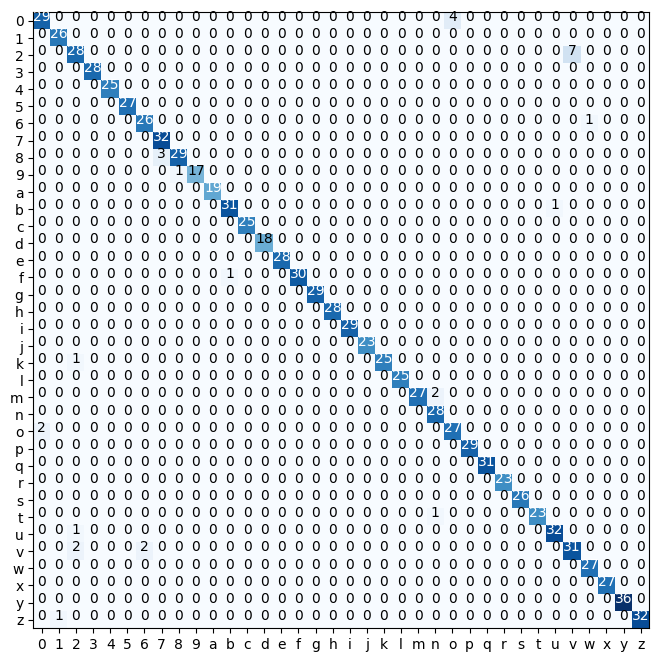

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.xticks(np.array([i for i in range(cm.shape[0])]),categories.values())
plt.yticks(np.array([i for i in range(cm.shape[0])]),categories.values())

plt.show()


In [30]:
def predict_image(img_path,normalizer,km):
    img = Image.open(img_path)  
    numpydata = asarray(img)

    if len(pixel_arrays)==3:
        gray_data = numpydata.mean(axis=2)
        gray_data = gray_data.astype(np.uint8)
    else:
        gray_data = numpydata.astype(np.uint8)

    kp, des = sift.detectAndCompute(gray_data, None)

    im_features = np.zeros(k, dtype=np.float32)
    
    for feature in des: #Para cada feature vemos a que cluster se acerca
        feature = feature.reshape(1, -1)
        idx = km.predict(feature)
        im_features[idx] += 1
    
    im_features = normalizer.transform(im_features.reshape(1,-1))

    y_pred = best_model.predict(im_features)
    
    return categories[y_pred[0]]


In [31]:
predict_image("asl_dataset/a/hand1_a_bot_seg_1_cropped.jpeg",scaler,kmeans)

'0'

In [32]:
predict_image("asl_dataset/b/hand1_b_bot_seg_1_cropped.jpeg",scaler,kmeans)

'0'

In [33]:
predict_image("asl_dataset/c/hand1_c_bot_seg_1_cropped.jpeg",scaler,kmeans)

'0'

In [34]:
predict_image("asl_dataset/d/hand1_d_bot_seg_2_cropped.jpeg",scaler,kmeans)

'0'

In [35]:
predict_image("asl_dataset/e/hand1_e_bot_seg_1_cropped.jpeg",scaler,kmeans)

'0'

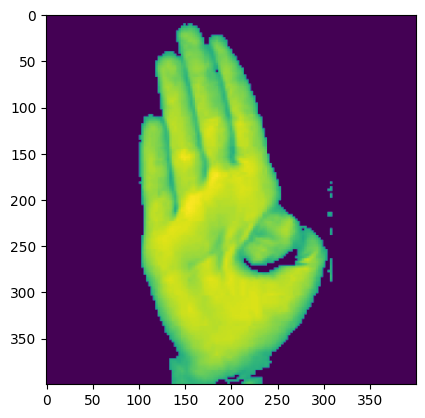

In [36]:
plt.imshow(plt.imread("resized_hand_image.png"))

In [37]:
predict_image("resized_hand_image.png",scaler,kmeans)

'0'